In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import math, random

import gym
import torch.optim as optim
import torch.nn.functional as F
USE_CUDA = torch.cuda.is_available()

from sklearn.manifold import MDS,TSNE,Isomap,LocallyLinearEmbedding
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


In [3]:
import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2
cv2.ocl.setUseOpenCL(False)

class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [4]:
"""
Deep Q Network
"""

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import math, random

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
USE_CUDA = torch.cuda.is_available()


class QLearner(nn.Module):
    def __init__(self, env, args, replay_buffer):
        super(QLearner, self).__init__()

        self.batch_size = args.batch_size
        self.gamma = args.gamma
        self.num_frames = args.num_frames
        self.replay_buffer = replay_buffer
        self.env = env
        self.input_shape = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.N = args.N


        self.features = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
            return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        action = []

        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), \
                               requires_grad=True)
            ######## YOUR CODE HERE! ########
            # TODO: Given state, you should write code to get the Q value and chosen action
            # Complete the R.H.S. of the following 2 lines and uncomment them
            q_value = self.forward(state)
            action = torch.argmax(q_value).item()
            ######## YOUR CODE HERE! ########
        else:
            action = random.randrange(self.env.action_space.n)
        return action

def compute_td_loss(model_Q, model_target_Q, batch_size, gamma, replay_buffer, N):

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))

    ######## YOUR CODE HERE! ########
    # TODO: Implement the Temporal Difference Loss

    # Compute current Q value, q_func takes only state and output value for every state-action pair
    # We choose Q based on action taken.
    q_value = model_Q.forward(state)
    current_q_value = q_value.gather(1, action.view(-1,1))
    # Compute next Q value based on which action gives max Q values
    # Detach variable from the current graph since we don't want gradients for next Q to propagated
    with torch.no_grad():
        next_q_value = model_target_Q.forward(next_state).detach()
        target_q_value = reward + (1-done) * gamma * torch.max(next_q_value.detach(),dim=1)[0]
        target_q_value = target_q_value.view(-1,1)

    # loss = torch.mean((target_q_val - current_q_value)**2))
    loss = F.smooth_l1_loss(current_q_value, target_q_value)
    ######## YOUR CODE HERE! ########
    return loss


class ReplayBuffer(object):
    def __init__(self, capacity):
        #Returns a new deque object initialized left-to-right
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # state = np.expand_dims(state, 0)
        # next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        ######## YOUR CODE HERE! ########
        # TODO: Randomly sampling data with specific batch size from the buffer
        # Hint: you may use the python library "random".

        batch = random.sample(self.buffer, batch_size)
        state,action,reward,next_state,done = zip(*batch)

        # If you are not familiar with the "deque" python library, please google it.
        ######## YOUR CODE HERE! ########
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)



In [5]:
class Args:
    def __init__(self):
        self.seed=1
        self.batch_size = 32
        self.num_frames = 1000000
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.99
        self.N = 1
        self.optimizer = 'Adam'
        self.lr = 3e-5
        self.number_of_updates = 10
        self.target_update_freq = 100
        self.capacity = 100000
        self.render = False
        self.save_result_path = '../results/DQN/results.npy'
        self.save_model_path = '../results/DQN/weights_only.pth'

## Set Args

In [6]:
args = Args()

## Set Env

In [7]:
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env, frame_stack=False)
env = wrap_pytorch(env)

## load best model and its log-file

In [8]:
model_result_path =  '../results/DQN/fmodel_best_19_lr1e-05_frame_1430000_framestack_False_scheduler_True_scheduler2_version2.pth'
log_path = 'slurm-90611.out'


# Representation of high-dim embedding data

In [9]:
"""
Representation of high-dim embedding data
"""

from sklearn.manifold import MDS,TSNE,Isomap,LocallyLinearEmbedding
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.autograd as autograd

import gym
from Wrapper.layers import *
from Wrapper.wrappers import make_atari, wrap_deepmind, wrap_pytorch
from models.dqn import QLearner, compute_td_loss, ReplayBuffer

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
USE_CUDA = torch.cuda.is_available()

In [12]:
parser = argparse.ArgumentParser()

args.embedding_type = 'fc_features'
# args.dim_red_method = 'tSNE' # choices=['PCA','KernelPCA','Isomap','LLE','MDS','tSNE'],
args.dim_red_method = 'tSNE' #'MDS'
args.kernel_pca = 'rbf' # choices=["linear", "poly", "rbf", "sigmoid", "cosine", "precomputed"],
args.kpca_gamma = 5
args.save_interim_dim_red = '../results/DQN/interim/dim_red_results/'

In [13]:
#---------------------------------------------------------------------------------------
# load best pre-trainned model
#---------------------------------------------------------------------------------------
# args = parser.parse_args()
#------
model_result_path =  '../results/DQN/fmodel_best_19_lr1e-05_frame_1430000_framestack_False_scheduler_True_scheduler2_version2.pth'
replay_initial = 1000
capacity = 1000
replay_buffer = ReplayBuffer(capacity)

env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env, frame_stack=False)
env = wrap_pytorch(env)

model_new = QLearner(env, args, replay_buffer)
model_new.load_state_dict(torch.load(model_result_path))
model_new = model_new.cuda()

#---------------------------------------------------------------------------------------
# load data that randomely sampled from replay-buffer using best pre-trainned model
#---------------------------------------------------------------------------------------
save_interim_dim_red = args.save_interim_dim_red
state      = np.load(save_interim_dim_red + 'state_sample_pretrainned_buffer.npy')
action     = np.load(save_interim_dim_red + 'action_sample_pretrainned_buffer.npy')
reward     = np.load(save_interim_dim_red + 'reward_sample_pretrainned_buffer.npy')
next_state = np.load(save_interim_dim_red + 'next_state_sample_pretrainned_buffer.npy')
done       = np.load(save_interim_dim_red + 'done_sample_pretrainned_buffer.npy')

state_batch      = Variable(torch.FloatTensor(np.float32(state)))
next_state_batch = Variable(torch.FloatTensor(np.float32(next_state)))
action_batch     = Variable(torch.LongTensor(action))
reward_batch     = Variable(torch.FloatTensor(reward))
done_batch       = Variable(torch.FloatTensor(done))


#---------------------------------------------------------------------------------------
# remapping the actions
#---------------------------------------------------------------------------------------
labels = action_batch.cpu().detach().numpy().copy()
actions_remap = labels.copy()

valid_actions = {'stay':0, 'up': 2, 'down': 3}
actions_remap[actions_remap==1] = valid_actions['stay']
actions_remap[actions_remap==4] = valid_actions['up']
actions_remap[actions_remap==5] = valid_actions['down']


#---------------------------------------------------------------------------------------
# extracting the embedding representations
#---------------------------------------------------------------------------------------
embedding_type = args.embedding_type

if embedding_type == 'out':
    state_embedding = model_new.forward(state1)
    state_embeddings = state_embedding.cpu().detach().numpy()
elif embedding_type == 'hidd_features':
    state_embedding = model_new.features(state1)
elif embedding_type == 'fc_features':
    state_batch1 = model_new.features(state_batch)
    state_batch2 = state_batch1.view(state_batch1.size(0), -1)
    fc_output = model_new.fc[0](state_batch2).cpu().detach().numpy()

state_embeddings = fc_output


#---------------------------------------------------------------------------------------
# apply dimentionality reduction method
#---------------------------------------------------------------------------------------
dim_red_method = args.dim_red_method

if dim_red_method=='PCA':
    pca_emb = PCA(n_components=2)
    pca_emb_2d = pca_emb.fit_transform(state_embeddings)
    np.save(args.save_interim_dim_red + 'pca_emb_2d.npy', pca_emb_2d)
    print('PCA done')

# elif dim_red_method=='KernelPCA':
#     kpca_emb = KernelPCA(n_components=2, kernel=args.kernel_pca, gamma=args.kpca_gamma)
#     kpca_emb_2d = kpca_emb.fit_transform(state_embeddings)
#     np.save(args.save_interim_dim_red + 'kpca_kernel_%s_gamma%s_emb_2d.npy' \
#             %(args.kernel_pca, args.kpca_gamma), kpca_emb_2d)
#     print('KernelPCA done')

# elif dim_red_method=='Isomap':
#     isomap_emb = Isomap(n_components=2)
#     isomap_emb_2d = isomap_emb.fit_transform(state_embeddings)
#     np.save(args.save_interim_dim_red + 'isomap_emb_2d.npy', isomap_emb_2d)
#     print('isomap done')

# elif dim_red_method=='LLE':
#     lle_emb = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=0, neighbors_algorithm='kd_tree')
#     lle_emb_2d = lle_emb.fit_transform(state_embeddings)
#     np.save(args.save_interim_dim_red + 'lle_emb_2d.npy', lle_emb_2d)
#     print('LLE done')

# elif dim_red_method=='MDS':
#     mds_emb = MDS(n_components=2)
#     mds_emb_2d = mds_emb.fit_transform(state_embeddings)
#     np.save(args.save_interim_dim_red + 'mds_emb_2d.npy', mds_emb_2d)
#     print('MDS done')

elif dim_red_method=='tSNE':
    tsne_emb = TSNE(n_components=2, perplexity=50)
    tsne_emb_2d = tsne_emb.fit_transform(state_embeddings)
    np.save(args.save_interim_dim_red + 'tsne_emb_2d.npy', tsne_emb_2d)
    print('done tSNE')



done tSNE


## Load embedding and plot them

In [226]:
def set_fonts():
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    return font

def plot_emb_scatter_all(embedding, actions, q_values, markers, title, save_fn, axs, is_save, side_info):

    font=set_fonts()   
    
    color_0 = q_values[actions==0]
    color_1 = q_values[actions==1]
    color_2 = q_values[actions==2]
    color_3 = q_values[actions==3]
    color_4 = q_values[actions==4]
    color_5 = q_values[actions==5]
    
    scatter1 = axs.scatter(embedding[actions==0, 0], embedding[actions==0, 1], c=color_0, label='Noop', marker='X')
#     plt.colorbar(scatter1)
    scatter2 = axs.scatter(embedding[actions==1, 0], embedding[actions==1, 1], c=color_1, label='Fire', marker = 'X')
#     plt.colorbar(scatter1\2)
    scatter3 = axs.scatter(embedding[actions==2, 0], embedding[actions==2, 1], c=color_2, label='Right', marker = '>')
    scatter4 = axs.scatter(embedding[actions==3, 0], embedding[actions==3, 1], c=color_3, label='Left', marker = '<')
    scatter5 = axs.scatter(embedding[actions==4, 0], embedding[actions==4, 1], c=color_4, label='Right-Fire', marker = '>')
    scatter6 = axs.scatter(embedding[actions==5, 0], embedding[actions==5, 1], c=color_5, label='Left-Fire', marker = '<')
#     plt.colorbar()
    axs.legend(handles=[scatter1, scatter2, scatter3, scatter4, scatter5, scatter6], \
               loc="upper right", title="Actions")

    axs.set_title(title, fontproperties=font, fontsize=20, fontweight='bold')
    axs.tick_params(          
        axis='both',
        which='both',
        bottom=False,
        top=False, 
        left=False,
        labelbottom=False,
        labelleft=False)       
    indx = []
    for ii, (x,y) in enumerate(zip(embedding[:,0],embedding[:,1])):      
        if ii%50==0:
            lbl = side_info[ii]
            axs.annotate(lbl, \
                         (x,y), \
                         textcoords="offset points", \
                         xytext=(0,1),
                         size=7, \
                         ha='center')
    
    
    if is_save:
        plt.savefig(save_fn, bbox_inches = 'tight', pad_inches = 0)

        
def plot_emb_scatter_remapped(embedding, actions, q_values, markers, title, save_fn, axs, is_save, side_info):

    font=set_fonts()   
    
    valid_actions = {'stay':0, 'up': 2, 'down': 3}
    actions[actions==1] = valid_actions['stay']
    actions[actions==4] = valid_actions['up']
    actions[actions==5] = valid_actions['down']

    color_0 = q_values[actions==0]
    color_2 = q_values[actions==2]
    color_3 = q_values[actions==3]
    
    scatter1 = axs.scatter(embedding[actions==0, 0], embedding[actions==0, 1], c=color_0, label='Stay', marker = 'X')
#     plt.colorbar(scatter1)
    scatter2 = axs.scatter(embedding[actions==2, 0], embedding[actions==2, 1], c=color_2, label='Up', marker = '^')
#     plt.colorbar(scatter2)
    scatter3 = axs.scatter(embedding[actions==3, 0], embedding[actions==3, 1], c=color_3, label='Down', marker = 'v')
#     plt.colorbar(scatter3)
    
    axs.legend(handles=[scatter1, scatter2, scatter3], loc="upper right", title="Actions")
    
    axs.set_title(title, fontproperties=font, fontsize=20, fontweight='bold')
    
    axs.tick_params(          
        axis='both',
        which='both',
        bottom=False,
        top=False, 
        left=False,
        labelbottom=False,
        labelleft=False)
    
    
    
    axs.ticklabel_format(style='plain',useOffset=False)

    for ii, (x,y) in enumerate(zip(embedding[:,0],embedding[:,1])):      
        if ii%50==0:
            lbl = side_info[ii]
            axs.annotate(lbl, \
                         (x,y), \
                         textcoords="offset points", \
                         xytext=(0,10),
#                          size=6, \
                         ha='center')
    if is_save:
        plt.savefig(save_fn, bbox_inches = 'tight', pad_inches = 0)

In [227]:
def set_fonts():
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    return font

def plot_emb_scatter_all_actColor(embedding, actions, q_values, markers, title, save_fn, axs, is_save, side_info):

    font=set_fonts()   
    
    color_0 = actions[actions==0]
    color_1 = actions[actions==1]
    color_2 = actions[actions==2]
    color_3 = actions[actions==3]
    color_4 = actions[actions==4]
    color_5 = actions[actions==5]
    
    scatter1 = axs.scatter(embedding[actions==0, 0], embedding[actions==0, 1], c='b', label='Noop', marker='X')
    scatter2 = axs.scatter(embedding[actions==1, 0], embedding[actions==1, 1], c='cyan', label='Fire', marker = '.')
    scatter3 = axs.scatter(embedding[actions==2, 0], embedding[actions==2, 1], c='g', label='Right', marker = '>')
    scatter4 = axs.scatter(embedding[actions==3, 0], embedding[actions==3, 1], c='orange', label='Left', marker = '<')
    scatter5 = axs.scatter(embedding[actions==4, 0], embedding[actions==4, 1], c='purple', label='Right-Fire', marker = '*')
    scatter6 = axs.scatter(embedding[actions==5, 0], embedding[actions==5, 1], c='yellow', label='Left-Fire', marker = '^')

    axs.legend(handles=[scatter1, scatter2, scatter3, scatter4, scatter5, scatter6], \
               loc="upper right", title="Actions")

    axs.set_title(title, fontproperties=font, fontsize=20, fontweight='bold')
    axs.tick_params(          
        axis='both',
        which='both',
        bottom=False,
        top=False, 
        left=False,
        labelbottom=False,
        labelleft=False)       

    for ii, (x,y) in enumerate(zip(embedding[:,0],embedding[:,1])):      
        if ii%50==0:
            lbl = side_info[ii]
            axs.annotate(lbl, \
                         (x,y), \
                         textcoords="offset points", \
                         xytext=(0,1),
#                          size=15, \
                         ha='center')
    if is_save:
        plt.savefig(save_fn, bbox_inches = 'tight', pad_inches = 0)

        
def plot_emb_scatter_remapped_actColor(embedding, actions, q_values, markers, title, save_fn, axs, is_save, side_info):

    font=set_fonts()   
    
    valid_actions = {'stay':0, 'up': 2, 'down': 3}
    actions[actions==1] = valid_actions['stay']
    actions[actions==4] = valid_actions['up']
    actions[actions==5] = valid_actions['down']

    color_0 = actions[actions==0]
    color_2 = actions[actions==2]
    color_3 = actions[actions==3]
    
    scatter1 = axs.scatter(embedding[actions==0, 0], embedding[actions==0, 1], c='b', label='Stay', marker = 'X')
    scatter2 = axs.scatter(embedding[actions==2, 0], embedding[actions==2, 1], c='g', label='Up', marker = '^')
    scatter3 = axs.scatter(embedding[actions==3, 0], embedding[actions==3, 1], c='orange', label='Down', marker = 'v')
    
    axs.legend(handles=[scatter1, scatter2, scatter3], loc="upper right", title="Actions")
    
    axs.set_title(title, fontproperties=font, fontsize=20, fontweight='bold')
    
    axs.tick_params(          
        axis='both',
        which='both',
        bottom=False,
        top=False, 
        left=False,
        labelbottom=False,
        labelleft=False)
    
    axs.ticklabel_format(style='plain',useOffset=False)

    for ii, (x,y) in enumerate(zip(embedding[:,0],embedding[:,1])):      
        if ii%50==0:
            lbl = side_info[ii]
            axs.annotate(lbl, \
                         (x,y), \
                         textcoords="offset points", \
                         xytext=(0,10),
#                          size=15, \
                         ha='center')
    if is_save:
        plt.savefig(save_fn, bbox_inches = 'tight', pad_inches = 0)

### load saved data

In [19]:
args.save_interim_dim_red = '../results/DQN/interim/dim_red_results/'
save_interim_dim_red = args.save_interim_dim_red

In [16]:
isomap_emb_2d       = np.load(save_interim_dim_red + 'isomap_emb_2d.npy')
lle_emb_2d          = np.load(save_interim_dim_red + 'lle_emb_2d.npy')
mds_emb_2d          = np.load(save_interim_dim_red + 'mds_emb_2d.npy')
tsne_emb_2d         = np.load(save_interim_dim_red + 'tsne_emb_2d.npy')
pca_emb_2d          = np.load(save_interim_dim_red + 'pca_emb_2d.npy')
kpca_cosine_gamma10 = np.load(save_interim_dim_red + 'kpca_kernel_cosine_gamma10.0_emb_2d.npy')
kpca_poly_gamma10   = np.load(save_interim_dim_red + 'kpca_kernel_poly_gamma10.0_emb_2d.npy')
kpca_rbf_gamma5     = np.load(save_interim_dim_red + 'kpca_kernel_rbf_gamma5.0_emb_2d.npy')
kpca_rbf_gamma10    = np.load(save_interim_dim_red + 'kpca_kernel_rbf_gamma10.0_emb_2d.npy')

In [17]:
#---------------------------------------------------------------------------------------
# load data that randomely sampled from replay-buffer using best pre-trainned model
#---------------------------------------------------------------------------------------
state      = np.load(save_interim_dim_red + 'state_sample_pretrainned_buffer.npy')
action     = np.load(save_interim_dim_red + 'action_sample_pretrainned_buffer.npy')
reward     = np.load(save_interim_dim_red + 'reward_sample_pretrainned_buffer.npy')
next_state = np.load(save_interim_dim_red + 'next_state_sample_pretrainned_buffer.npy')
done       = np.load(save_interim_dim_red + 'done_sample_pretrainned_buffer.npy')

state_batch      = Variable(torch.FloatTensor(np.float32(state)))
next_state_batch = Variable(torch.FloatTensor(np.float32(next_state)))
action_batch     = Variable(torch.LongTensor(action))
reward_batch     = Variable(torch.FloatTensor(reward))
done_batch       = Variable(torch.FloatTensor(done))

In [30]:
q_value = model_new.forward(state_batch)
# current_q_value = torch.max(q_value.detach(),dim=1)[0].cpu().detach().numpy().copy()
current_q_value = q_value.gather(1, action_batch.view(-1,1)).cpu().detach().numpy().copy()
current_q_value.shape

(1000, 1)

### remapping the actions

In [127]:
#---------------------------------------------------------------------------------------
# remapping the actions
#---------------------------------------------------------------------------------------
labels = action_batch.cpu().detach().numpy().copy()
actions_remap = labels.copy()

### extracting the embedding representations

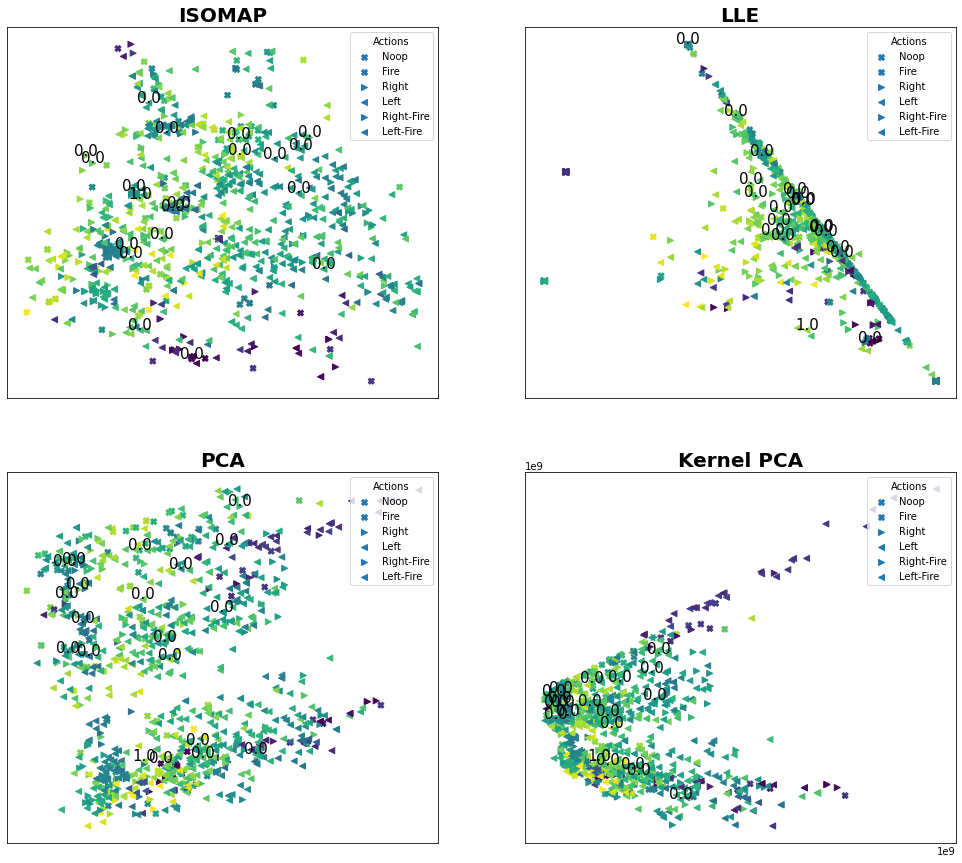

In [102]:
side_info = reward.copy()
markers_batch=[]
fgs1=17; fgs2=15;
fig, axs = plt.subplots(2,2,figsize=(fgs1,fgs2), edgecolor='w')

plot_emb_scatter_all(isomap_emb_2d, actions_remap, current_q_value, markers_batch, "ISOMAP", '', axs[0, 0], 0, side_info)
plot_emb_scatter_all(lle_emb_2d, actions_remap, current_q_value, markers_batch, "LLE", '', axs[0,1], 0, side_info)
plot_emb_scatter_all(pca_emb_2d, actions_remap, current_q_value, markers_batch, "PCA", '', axs[1,0], 0, side_info)
plot_emb_scatter_all(kpca_poly_gamma10, actions_remap, current_q_value, markers_batch, "Kernel PCA", '', axs[1,1], 0, side_info)
# plt.colorbar(sc)
plt.show()


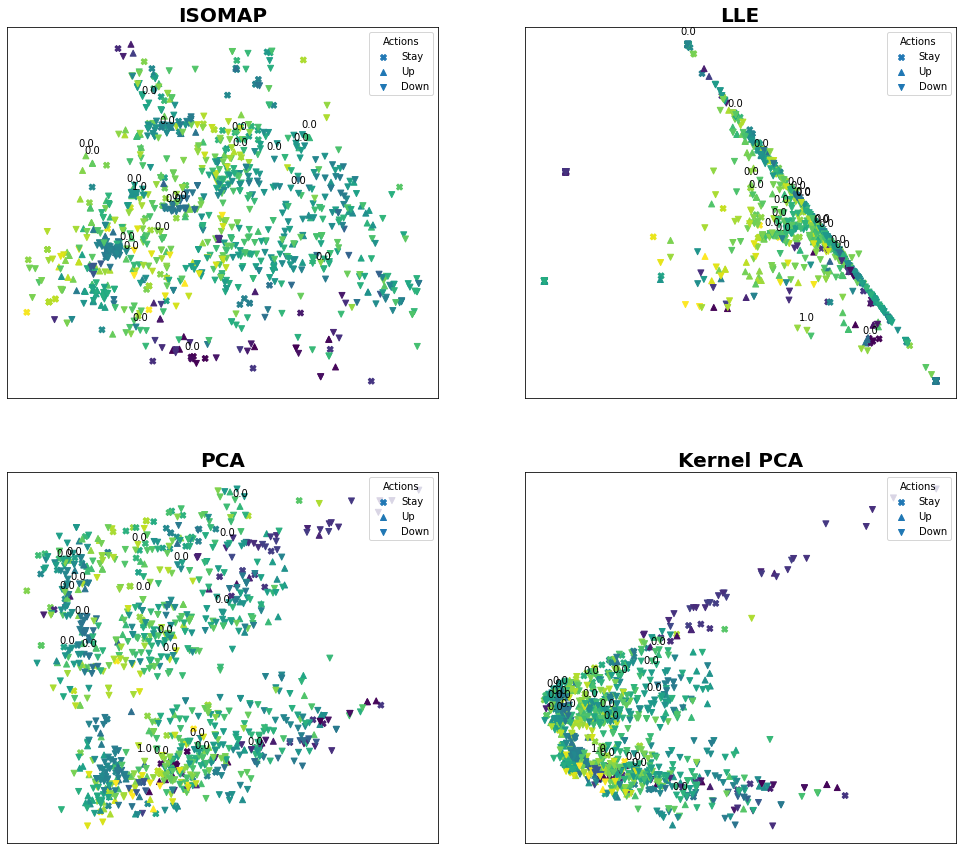

In [236]:
side_info = reward.copy()
markers_batch=[]
fgs1=17; fgs2=15;
fig, axs = plt.subplots(2,2,figsize=(fgs1,fgs2), edgecolor='w')

plot_emb_scatter_remapped(isomap_emb_2d, actions_remap, current_q_value, markers_batch, "ISOMAP", '', axs[0, 0], 0, side_info)
plot_emb_scatter_remapped(lle_emb_2d, actions_remap, current_q_value, markers_batch, "LLE", '', axs[0,1], 0, side_info)
plot_emb_scatter_remapped(pca_emb_2d, actions_remap, current_q_value, markers_batch, "PCA", '', axs[1,0], 0, side_info)
plot_emb_scatter_remapped(kpca_poly_gamma10, actions_remap, current_q_value, markers_batch, "Kernel PCA", '', axs[1,1], 0, side_info)

plt.show()



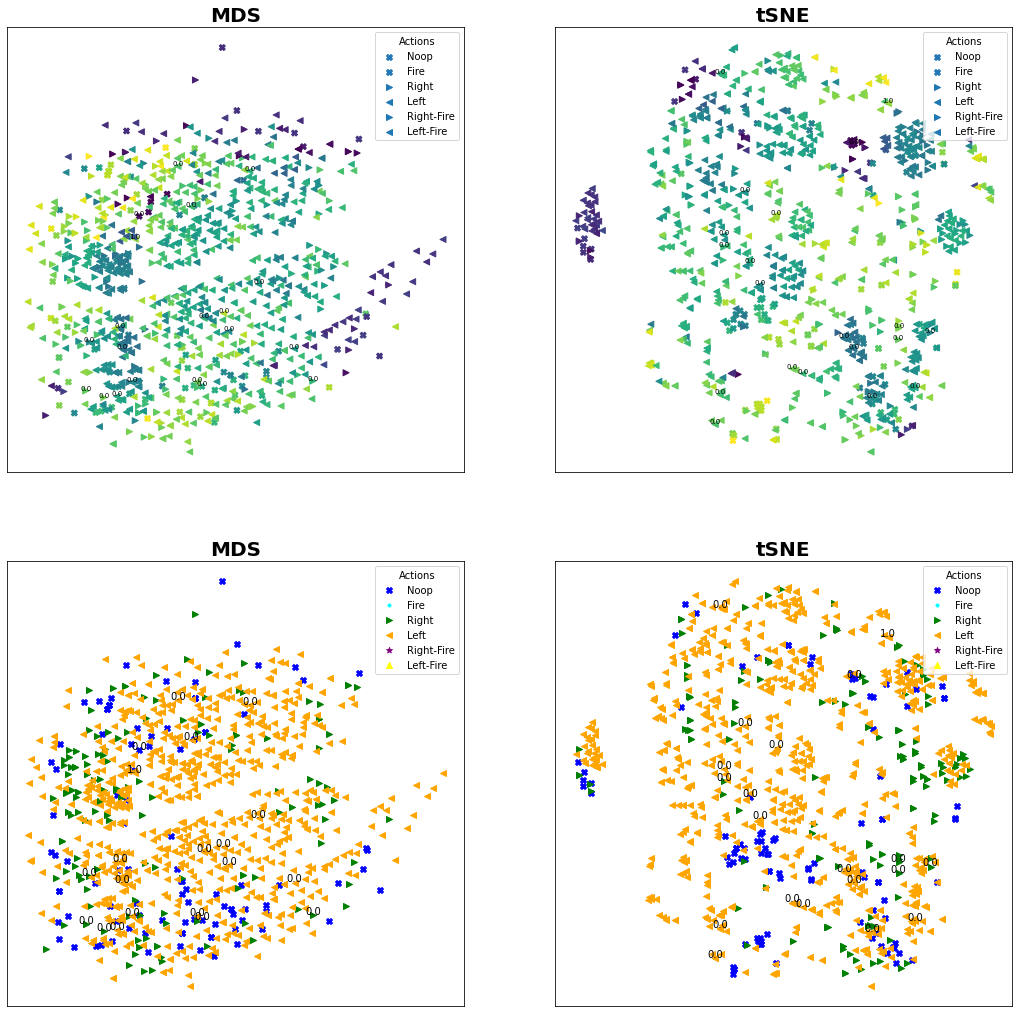

In [235]:
side_info = reward.copy()
markers_batch=[]
fgs1=18; fgs2=18
;
fig, axs = plt.subplots(2,2,figsize=(fgs1,fgs2), edgecolor='w')


plot_emb_scatter_all(mds_emb_2d, actions_remap, current_q_value, markers_batch, "MDS", '', axs[0,0], 0, side_info)
plot_emb_scatter_all(tsne_emb_2d, actions_remap, current_q_value, markers_batch, "tSNE", '', axs[0,1], 0, side_info)

plot_emb_scatter_all_actColor(mds_emb_2d, actions_remap, current_q_value, markers_batch, "MDS", '', axs[1,0], 0, side_info)
plot_emb_scatter_all_actColor(tsne_emb_2d, actions_remap, current_q_value, markers_batch, "tSNE", '', axs[1,1], 0, side_info)


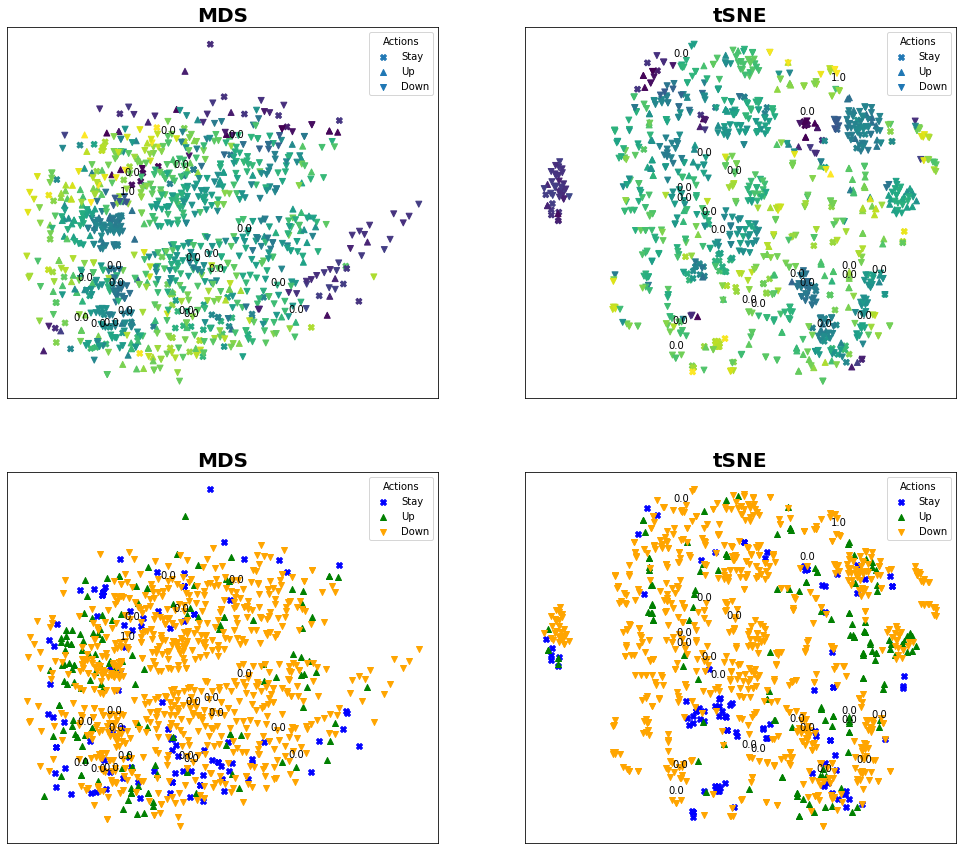

In [231]:
side_info = reward.copy()
markers_batch=[]
fgs1=17; fgs2=15;
fig, axs = plt.subplots(2,2,figsize=(fgs1,fgs2), edgecolor='w')


plot_emb_scatter_remapped(mds_emb_2d, actions_remap, current_q_value, markers_batch, "MDS", '', axs[0,0], 0, side_info)
plot_emb_scatter_remapped(tsne_emb_2d, actions_remap, current_q_value, markers_batch, "tSNE", '', axs[0,1], 0, side_info)

plot_emb_scatter_remapped_actColor(mds_emb_2d, actions_remap, current_q_value, markers_batch, "MDS", '', axs[1,0], 0, side_info)
plot_emb_scatter_remapped_actColor(tsne_emb_2d, actions_remap, current_q_value, markers_batch, "tSNE", '', axs[1,1], 0, side_info)


In [ ]:
# q_values < 1.25
# q_values >=1.25 && q_values < 1.75
# q_values >=1.75 && q_values < 2.25
# q_values >=2.25 && q_values < 2.5
# q_values >=2.5 && q_values <= 3

In [138]:
actions2 = actions_remap.copy()

valid_actions = {'stay':0, 'up': 2, 'down': 3}
actions2[actions2==1] = valid_actions['stay']
actions2[actions2==4] = valid_actions['up']
actions2[actions2==5] = valid_actions['down']
indx = np.range 
x1 = tsne_emb_2d[actions2==0,0]
y1 = tsne_emb_2d[actions2==0,1]

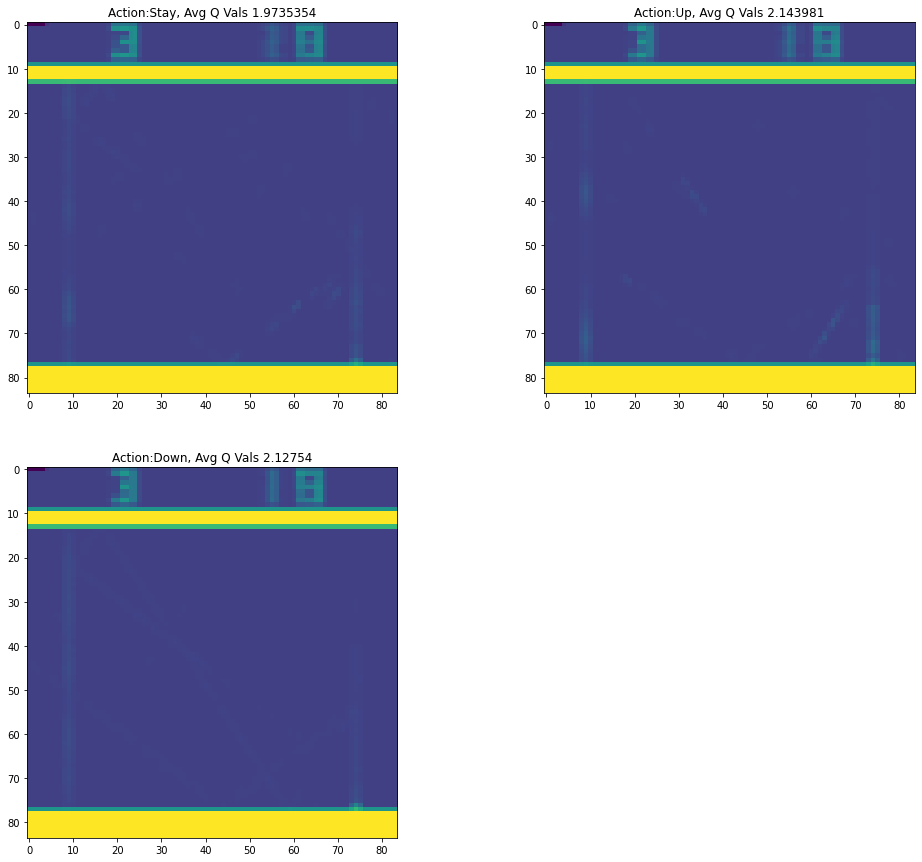

In [234]:
states_orig = state_batch.cpu().detach().numpy().copy()
img1 = np.mean(states_orig[actions2==0].squeeze().T, axis=2)
img2 = np.mean(states_orig[actions2==2].squeeze().T, axis=2)
img3 = np.mean(states_orig[actions2==3].squeeze().T, axis=2)

avg1 = np.mean(current_q_value[actions2==0].squeeze().T)
avg2 = np.mean(current_q_value[actions2==2].squeeze().T)
avg3 = np.mean(current_q_value[actions2==3].squeeze().T)

fig, axs = plt.subplots(2,2,figsize=(fgs1,fgs2), edgecolor='w')

axs[0,0].imshow(img1)
axs[0,0].set_title('Action:Stay, Avg Q Vals %s' %(avg1))

axs[0,1].imshow(img2)
axs[0,1].set_title('Action:Up, Avg Q Vals %s' %(avg2))

axs[1,0].imshow(img3)
axs[1,0].set_title('Action:Down, Avg Q Vals %s' %(avg3))

axs[1,1].remove()

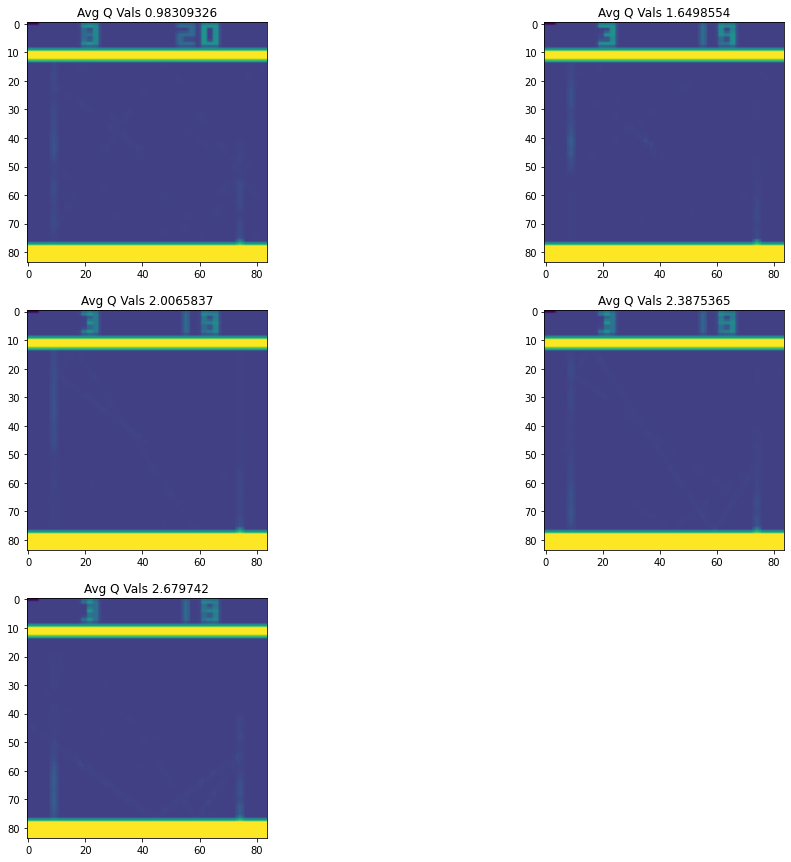

In [232]:
states_orig = state_batch.cpu().detach().numpy().copy()
img1 = np.mean(states_orig[current_q_value < 1.25].squeeze().T, axis=2)
img2 = np.mean(states_orig[(current_q_value >=1.25) & (current_q_value < 1.75)].squeeze().T, axis=2)
img3 = np.mean(states_orig[(current_q_value >=1.75) & (current_q_value < 2.25)].squeeze().T, axis=2)
img4 = np.mean(states_orig[(current_q_value >=2.25) & (current_q_value < 2.5)].squeeze().T, axis=2)
img5 = np.mean(states_orig[(current_q_value >=2.5) & (current_q_value <= 3)].squeeze().T, axis=2)

avg1 = np.mean(current_q_value[current_q_value < 1.25].squeeze().T)
avg2 = np.mean(current_q_value[(current_q_value >=1.25) & (current_q_value < 1.75)].squeeze().T)
avg3 = np.mean(current_q_value[(current_q_value >=1.75) & (current_q_value < 2.25)].squeeze().T)
avg4 = np.mean(current_q_value[(current_q_value >=2.25) & (current_q_value < 2.5)].squeeze().T)
avg5 = np.mean(current_q_value[(current_q_value >=2.5) & (current_q_value <= 3)].squeeze().T)

fig, axs = plt.subplots(3,2,figsize=(fgs1,fgs2), edgecolor='w')

axs[0,0].imshow(img1)
axs[0,0].set_title('Avg Q Vals %s' %(avg1))

axs[0,1].imshow(img2)
axs[0,1].set_title('Avg Q Vals %s' %(avg2))

axs[1,0].imshow(img3)
axs[1,0].set_title('Avg Q Vals %s' %(avg3))

axs[1,1].imshow(img4)
axs[1,1].set_title('Avg Q Vals %s' %(avg4))

axs[2,0].imshow(img5)
axs[2,0].set_title('Avg Q Vals %s' %(avg5))

axs[2,1].remove()

In [ ]:
plt.imsave('sample_state.png', state[0], cmap='gray')